In [ ]:
import sys
sys.path.append('../src')

import warnings

# Global suppression
warnings.filterwarnings("ignore", message="Parsing dates in .* when dayfirst=True was specified")
warnings.filterwarnings("ignore", category=FutureWarning)

from preprocessing import *
import tame
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def _cuda(obj):
    if isinstance(obj, torch.nn.Module):
        return obj.cuda()
    elif isinstance(obj, torch.Tensor):
        return obj.cuda()
    elif isinstance(obj, np.ndarray):
        return torch.from_numpy(obj).cuda()
    
def index_value(data):
    index = data // (CONFIG['split_num'] + 1)
    value = data % (CONFIG['split_num'] + 1)
    index = Variable(_cuda(index))
    value = Variable(_cuda(value))
    return [index, value]

In [2]:
dfs = get_dfs()
biopsy_df = dfs['biopsy'].copy()
static_df= create_static_df(dfs)
vital_df = create_vitals_df(dfs, static_df)
med_df = create_medication_df(dfs, static_df)
lab_df = create_lab_values_df(dfs, static_df)
ts_data = create_ts_df(vital_df, lab_df, med_df, merge_lab=True, merge_med=True)
print(ts_data.columns)

max rel_days 8034
max number of rows across all patients 1105
Index(['patient_id', 'transplant_id', 'rel_days', 'bp_sys', 'bp_dia', 'weight',
       'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin',
       'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01',
       'L04AD02'],
      dtype='object')


In [3]:
full_dataset = NephroDataset(static_df, ts_data, biopsy_df, phase='test')
categorical_cardenalities = full_dataset.categorical_cardinalities
print("Categorical cardinalities:", categorical_cardenalities)

Categorical cardinalities: [438, 9, 3, 3, 9, 10, 2, 3]


In [4]:
# Find a random patient with graft_loss_label == 1
def get_random_positive_sample(dataset):
    positive_indices = []
    print("Scanning dataset for positive graft loss labels...")

    for i in range(len(dataset)):
        sample = dataset[i]
        if sample['seq_len'] < 200:
            if sample['graft_loss_label'] == 1:
                positive_indices.append(i)

    if not positive_indices:
        raise ValueError("No samples with graft_loss_label == 1 found.")
    
    return positive_indices

pos_indices = get_random_positive_sample(full_dataset)


Scanning dataset for positive graft loss labels...


In [ ]:
random_index = np.random.choice(pos_indices)
# Select the sample and wrap it in a DataLoader
sample = full_dataset[random_index]
sample_dataloader = DataLoader([sample], batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [ ]:
checkpoint = torch.load('../model_checkpoints/models/best.ckpt', weights_only=False)
print(checkpoint.keys())
print(checkpoint['epoch'])
model = tame.AutoEncoder(categorical_cardinalities=categorical_cardenalities)
#Load weights
model.load_state_dict(checkpoint['state_dict'])

dict_keys(['epoch', 'best_metric', 'state_dict', 'best r2s'])
33


In [ ]:
# print graft loss and rejection for our sample
for sample in sample_dataloader:
    print(sample['patient_id'])
    print(sample['loss_rel_days'])
    print(sample['rej_rel_days_list'])

In [ ]:
# get attention weights
model.eval()  # important: disables dropout, etc.
model = model.to(device)  # Move model to GPU if needed

with torch.no_grad():
    for batch in sample_dataloader:
        # Move inputs to GPU if needed
        data = index_value(batch['input_ts_features'])
        label = Variable(_cuda(batch['output_ts_features']))
        neib = [index_value(batch['pre_input']), Variable(_cuda(batch['pre_time'])), index_value(batch['post_input']), Variable(_cuda(batch['post_time']))]

        static_num = Variable(_cuda(batch['static_numerical_features']))
        static_cat = Variable(_cuda(batch['static_categorical_features']))

        seq_len = _cuda(batch['seq_len'])
        pad_mask = Variable(_cuda(batch['mask']))
        print(pad_mask.shape)
        print("Non-zero entries:", pad_mask.sum().item())

        value_mask = batch['value_mask']

        tm_i = batch['real_ts_data'][0, :seq_len, 0].cpu().numpy().flatten() #time steps

        patient_id = batch['patient_id']
        print("Patient ID:", patient_id)
        # Forward pass
        attention_weights = model(data, neib, static_num, static_cat, mask=pad_mask, plot_att=True)

        print("✅ Sample output:", attention_weights.shape)

torch.Size([1, 200])
Non-zero entries: 64
Patient ID: ['9303']
✅ Sample output: torch.Size([1, 200, 32, 256])


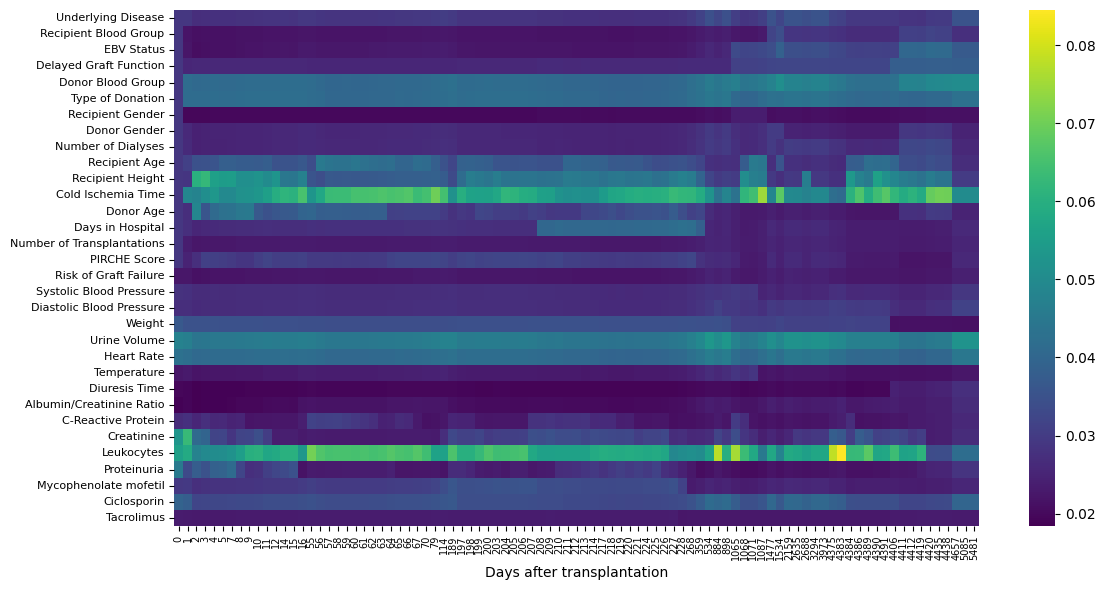

In [ ]:
# plot attention weights
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Average over embedding dimension D ===
attn_mean = attention_weights.mean(dim=-1)  # [1, T, N]

# === Step 2: Remove batch dimension and truncate to seq_len ===
attn_mean = attn_mean[0][:seq_len]  # [seq_len, N]

# === Step 3: Transpose for plotting (features on Y-axis) ===
attn_plot = attn_mean.T.cpu().numpy()  # [N, seq_len]

# === Step 4: Prepare x-axis labels ===
x_labels = tm_i.astype(int)

feature_names = (
    CONFIG['static_categorical_feat'] +
    CONFIG['static_numerical_feat'] +
    CONFIG['ts_feat']
)

feature_map = {
    'L04AA06': 'Mycophenolate mofetil',
    'L04AD02': 'Tacrolimus',
    'L04AD01': 'Ciclosporin',
    'underlying_disease': 'Underlying Disease',
    'type_of_donation': 'Type of Donation', 
    'blood_group': 'Recipient Blood Group',
    'ebv_status': 'EBV Status', 
    'delayed_graft_function': 'Delayed Graft Function',  
    'donor_bloodgroup': 'Donor Blood Group',
    'gender': 'Recipient Gender', 
    'gender_donor': 'Donor Gender',
    'number_dialyses': 'Number of Dialyses', 
    'age': 'Recipient Age', 
    'height': 'Recipient Height', 
    'cold_ischemia_time': 'Cold Ischemia Time',
    'age_donor': 'Donor Age', 
    'days_in_hospital': 'Days in Hospital', 
    'number_transplantation': 'Number of Transplantations',
    'pirche_score': 'PIRCHE Score', 
    'risk_of_graft_failure': 'Risk of Graft Failure',
    'bp_sys': 'Systolic Blood Pressure', 
    'bp_dia': 'Diastolic Blood Pressure', 
    'weight': 'Weight', 
    'urine_volume': 'Urine Volume', 
    'heart_rate': 'Heart Rate', 
    'temperature': 'Temperature', 
    'diuresis_time': 'Diuresis Time', 
    'albumin': 'Albumin/Creatinine Ratio', 
    'crphp': 'C-Reactive Protein',
    'creatinine': 'Creatinine', 
    'leukocyte': 'Leukocytes', 
    'proteinuria': 'Proteinuria', 
}

ts_feature_names = feature_names[-attn_plot.shape[0]:]
y_labels = [feature_map.get(feat, feat) for feat in ts_feature_names]
# === Step 5: Plot ===
plt.figure(figsize=(12, 6))
sns.heatmap(attn_plot, cmap='viridis', cbar=True,
            xticklabels=x_labels, yticklabels=y_labels)
plt.xticks(rotation=90, fontsize=7)  # or fontsize=6 for even smaller
plt.yticks(fontsize=8)
plt.xlabel("Days after transplantation")
plt.tight_layout()
plt.show()


In [ ]:
# get model's output
model.eval()  # important: disables dropout, etc.
model = model.to(device)  # Move model to GPU if needed

with torch.no_grad():
    for batch in sample_dataloader:
        # Move inputs to GPU if needed
        data = index_value(batch['input_ts_features'])
        label = Variable(_cuda(batch['output_ts_features']))
        neib = [index_value(batch['pre_input']), Variable(_cuda(batch['pre_time'])), index_value(batch['post_input']), Variable(_cuda(batch['post_time']))]

        static_num = Variable(_cuda(batch['static_numerical_features']))
        static_cat = Variable(_cuda(batch['static_categorical_features']))
        pad_mask = Variable(_cuda(batch['mask']))

        seq_len = _cuda(batch['seq_len'])

        patient_id = batch['patient_id']
        print("Patient ID:", patient_id)
        # Forward pass
        output = model(data, neib, static_num, static_cat, mask=pad_mask)

        print("✅ Sample output:", output.shape)

Patient ID: ['6290']
✅ Sample output: torch.Size([1, 200, 15])


Sequence length: 129
torch.Size([129, 16]) torch.Size([200, 15])


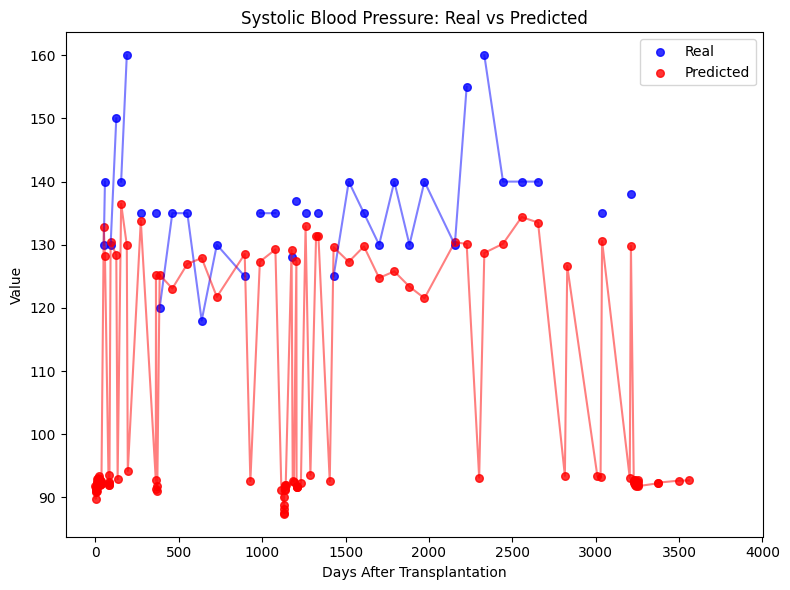

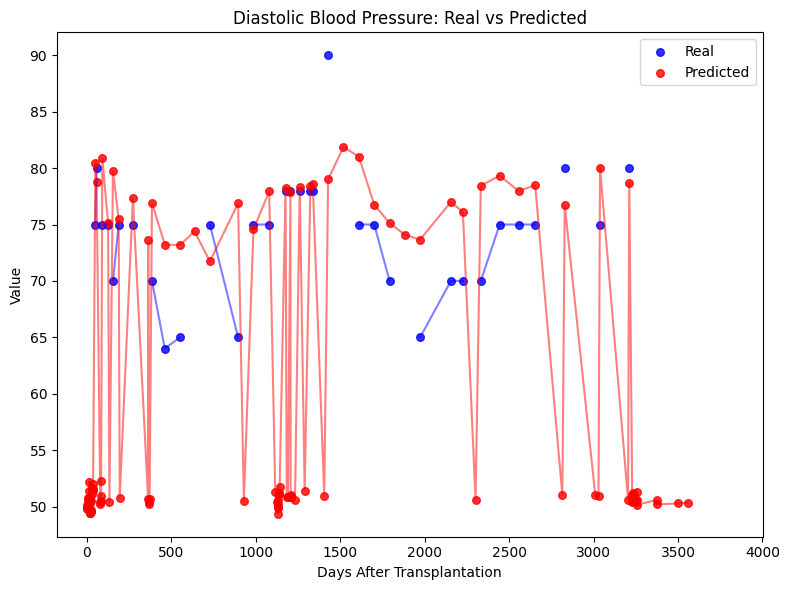

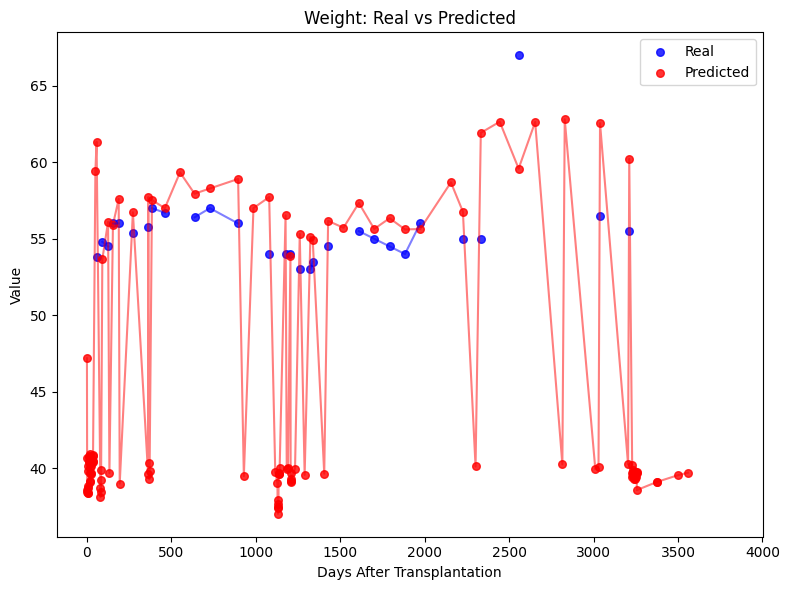

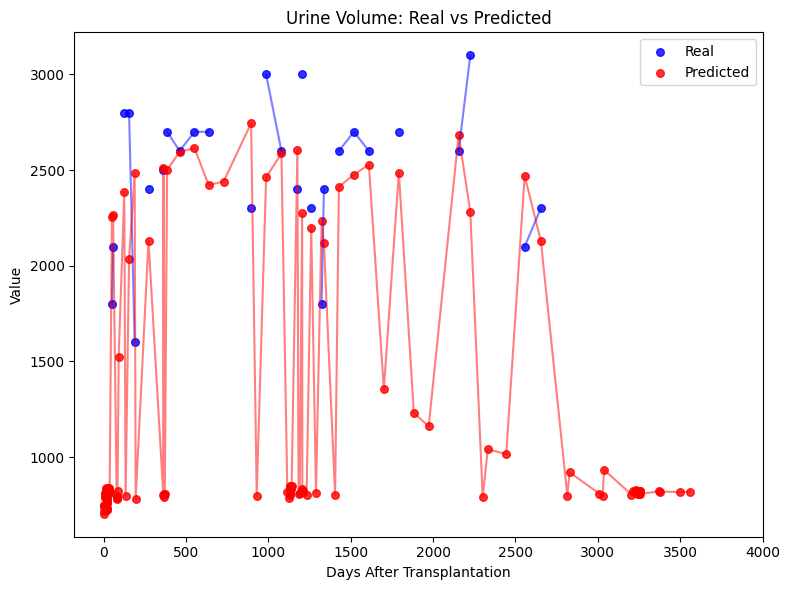

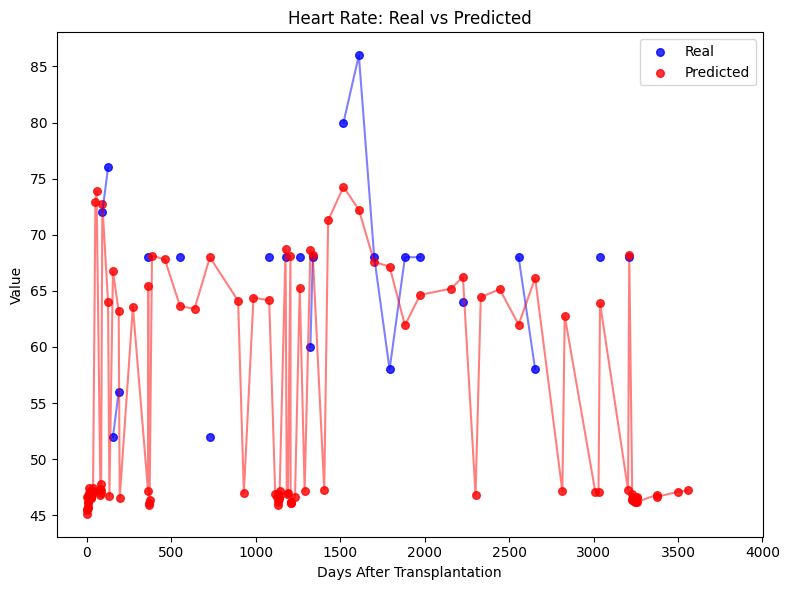

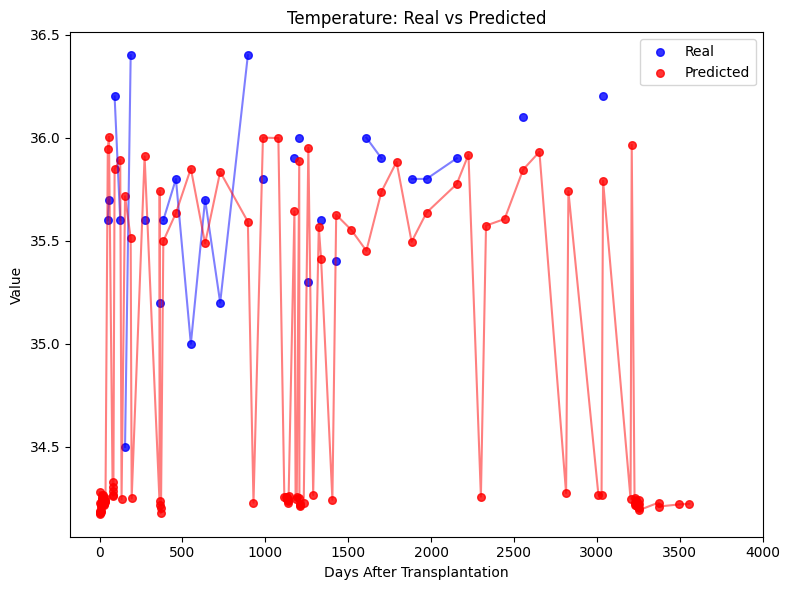

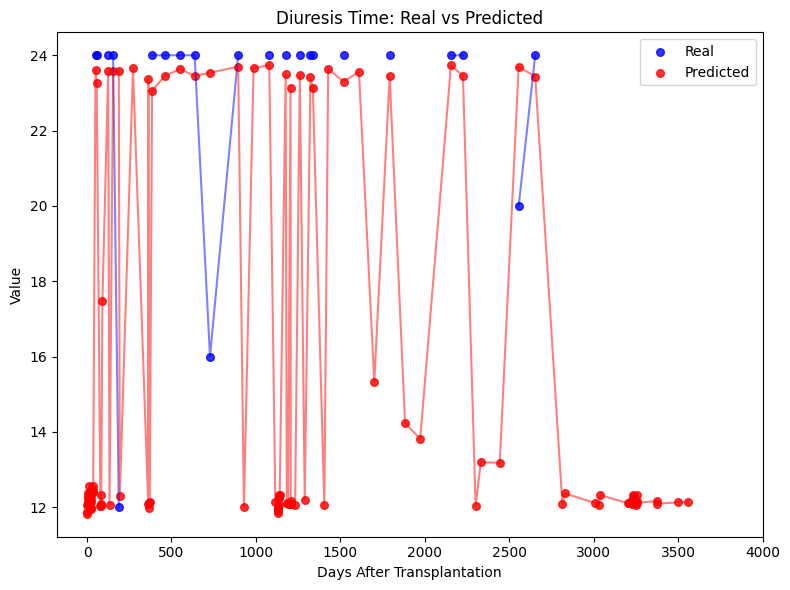

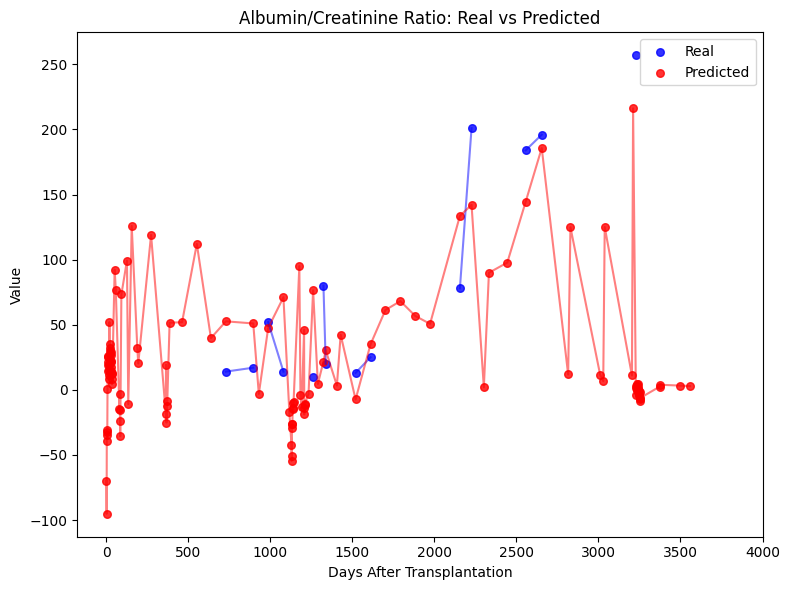

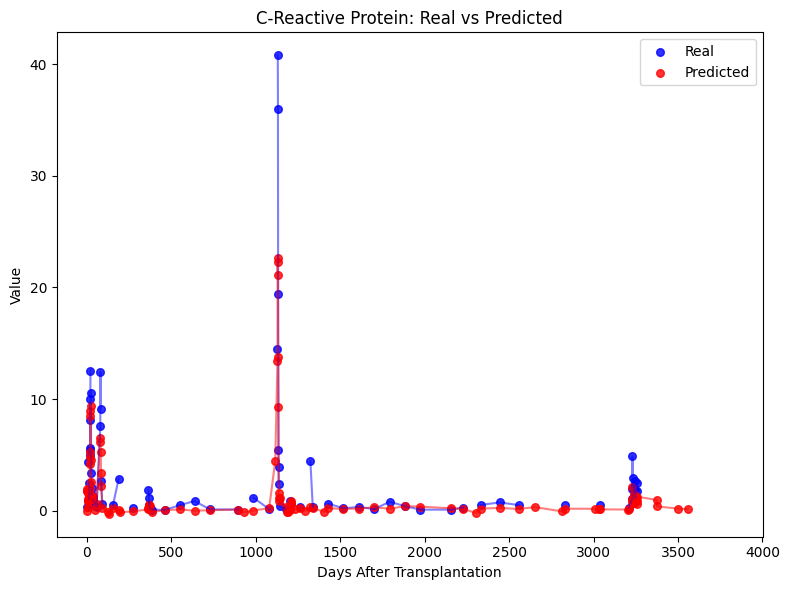

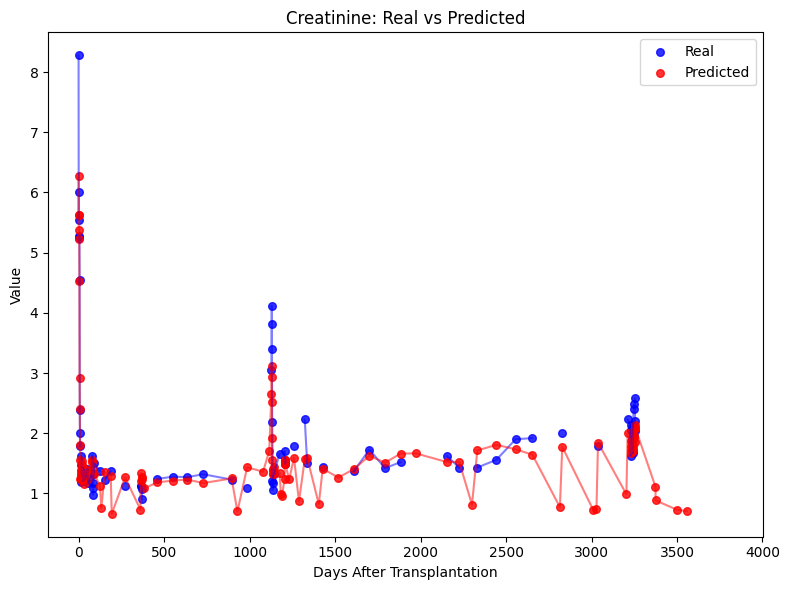

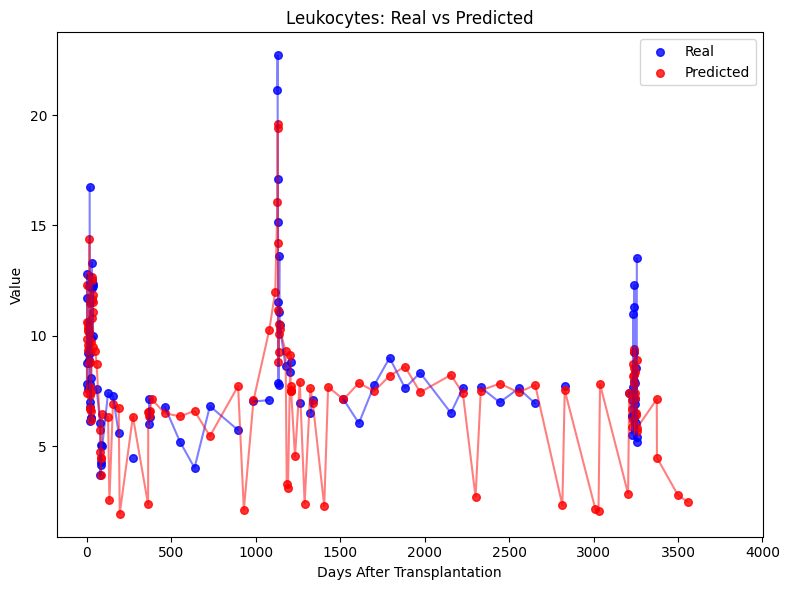

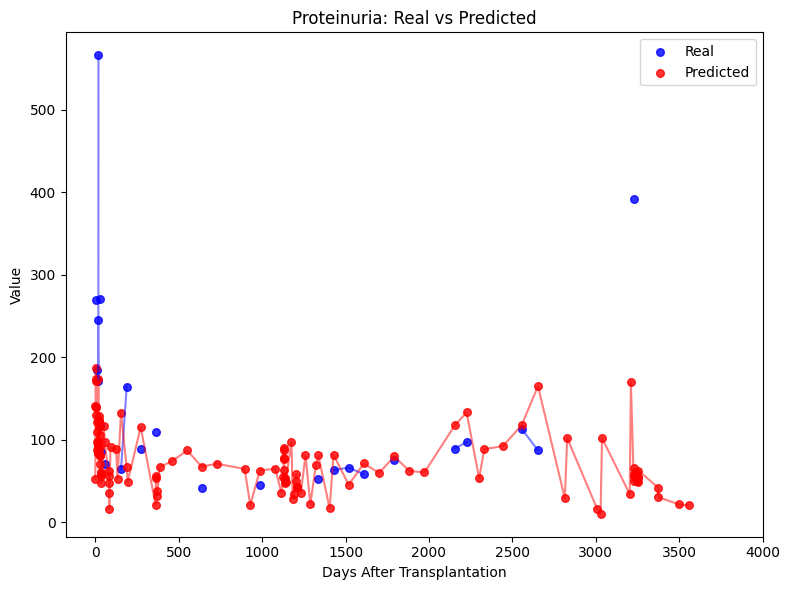

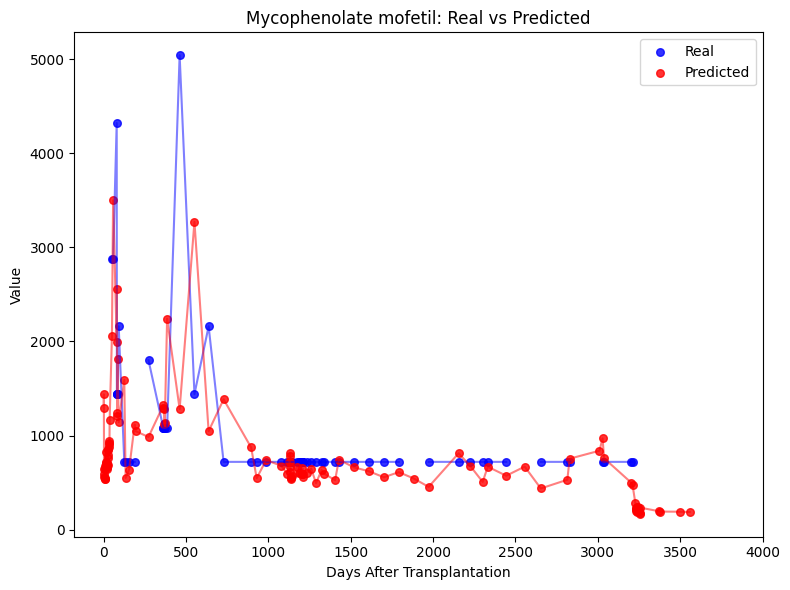

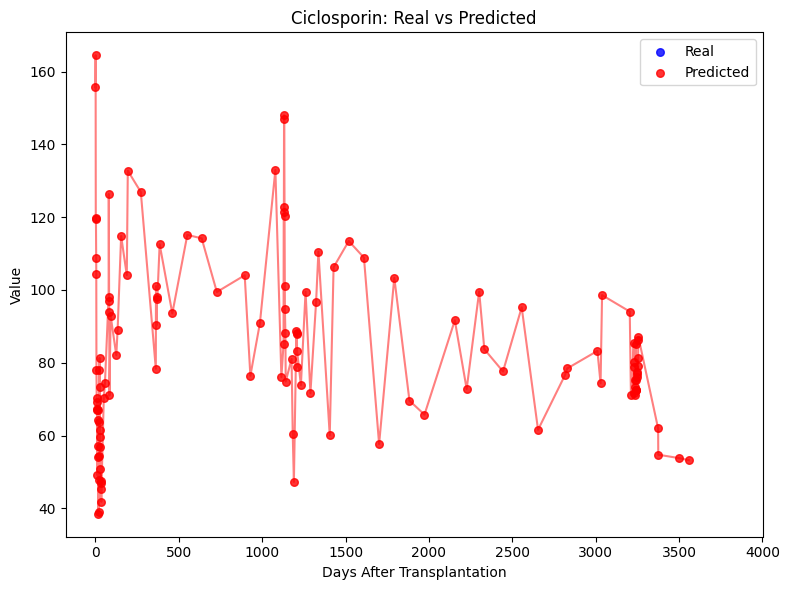

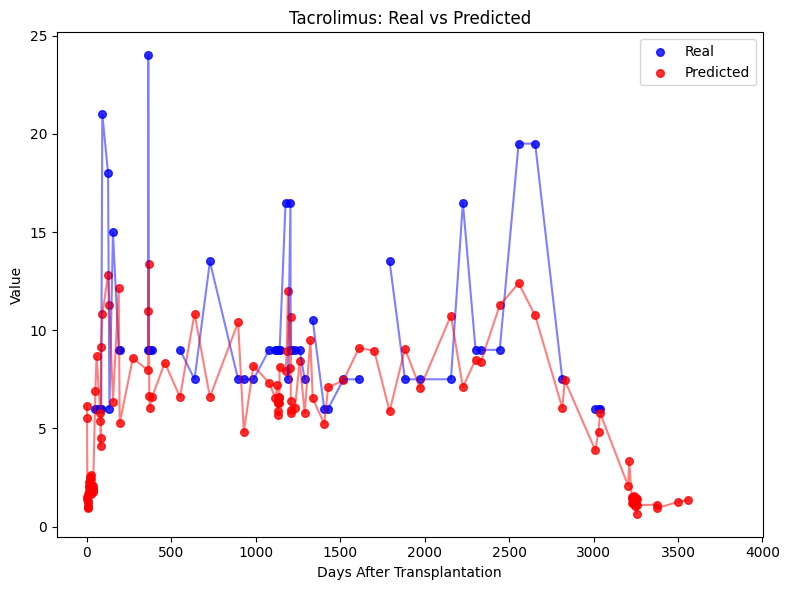

In [ ]:
# plot each feature
feature_map = {
    'L04AA06': 'Mycophenolate mofetil',
    'L04AD02': 'Tacrolimus',
    'L04AD01': 'Ciclosporin',
    'underlying_disease': 'Underlying Disease',
    'type_of_donation': 'Type of Donation', 
    'blood_group': 'Recipient Blood Group',
    'ebv_status': 'EBV Status', 
    'delayed_graft_function': 'Delayed Graft Function',  
    'donor_bloodgroup': 'Donor Blood Group',
    'gender': 'Recipient Gender', 
    'gender_donor': 'Donor Gender',
    'number_dialyses': 'Number of Dialyses', 
    'age': 'Recipient Age', 
    'height': 'Recipient Height', 
    'cold_ischemia_time': 'Cold Ischemia Time',
    'age_donor': 'Donor Age', 
    'days_in_hospital': 'Days in Hospital', 
    'number_transplantation': 'Number of Transplantations',
    'pirche_score': 'PIRCHE Score', 
    'risk_of_graft_failure': 'Risk of Graft Failure',
    'bp_sys': 'Systolic Blood Pressure', 
    'bp_dia': 'Diastolic Blood Pressure', 
    'weight': 'Weight', 
    'urine_volume': 'Urine Volume', 
    'heart_rate': 'Heart Rate', 
    'temperature': 'Temperature', 
    'diuresis_time': 'Diuresis Time', 
    'albumin': 'Albumin/Creatinine Ratio', 
    'crphp': 'C-Reactive Protein',
    'creatinine': 'Creatinine', 
    'leukocyte': 'Leukocytes', 
    'proteinuria': 'Proteinuria', 
}

# ---- 2. Function to map names ----
def map_feature_names(features, feature_map):
    """Replace codes with readable names if available."""
    return [feature_map.get(f, f) for f in features]

# ---- 3. Apply mapping to CONFIG ----
CONFIG_mapped = {}
for key, val in CONFIG.items():
    if isinstance(val, list):
        CONFIG_mapped[key] = map_feature_names(val, feature_map)
    else:
        CONFIG_mapped[key] = val

# load feature_mm file
with open('../feature_mm.json', 'r') as f:
    feature_mm = json.load(f)

# After loading feature_mm
keys = list(feature_mm.keys())  # careful: assumes insertion order matches model

mins = torch.tensor([feature_mm[keys[i]][0] for i in range(15)], device=device)
maxs = torch.tensor([feature_mm[keys[i]][1] for i in range(15)], device=device)


output_real = output * (maxs - mins)[None, None, :] + mins[None, None, :]

real = sample['real_ts_data'] # shape: [T, D]
pred = output_real[0]                  # shape: [T, D1]
seq_len = sample['seq_len']
print("Sequence length:", seq_len)

print(real.shape, pred.shape)

# Use the first column of real as time axis
time_axis = real[:seq_len, 0].cpu().numpy()

num_features = pred.shape[1]

for i in range(num_features):
    real_i = real[:seq_len, i + 1].cpu().numpy()           # +1 to skip time column
    pred_i = pred[:seq_len, i].detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(time_axis, real_i, label="Real", color='blue', s=30, alpha=0.8)
    plt.plot(time_axis, real_i, color='blue', alpha=0.5)
    plt.scatter(time_axis, pred_i, label="Predicted", color='red', s=30, alpha=0.8)
    plt.plot(time_axis, pred_i, color='red', alpha=0.5)
    plt.title(f"{CONFIG_mapped['ts_feat'][i]}: Real vs Predicted")
    plt.xlabel("Days After Transplantation")
    plt.ylabel("Value")
    plt.xticks(
    np.arange(start=np.floor(time_axis.min() / 500) * 500, 
              stop=np.ceil(time_axis.max() / 500) * 500 + 1, 
              step=500)
    )
    plt.legend()
    plt.tight_layout()
    plt.show()

